Initialization

In [391]:
import math
import json
import os
import random
from IPython import display
import sympy as sp
import numpy as np
import pandas as pd
import sklearn


GREEN = "\033[92m"
RED = "\033[91m"
YELLOW = "\033[93m"
BLUE = "\033[94m"
CYAN = "\033[96m"
MAGENTA = "\033[95m"
BOLD = "\033[1m"
UNDERLINE = "\033[4m"
STANDARD = "\033[0m"

%run config.py

In [392]:
def csv2sequence(csvFile,seqFile,pref):
	with open(csvFile, 'r') as f:
		lines = f.readlines()
		with open(seqFile, 'w') as g:
			for line in lines:
				for token in line.split(','):
					if token.startswith(pref):
						token = token[len(pref):]
					token = token.strip()
					if token!="" and token!='\n':
						g.write(token+'\n')

def sequence2csv(seqFile,csvFile,dataWidth,pref):
	with open(seqFile, 'r') as f:
		lines = f.readlines()
		dataW = dataWidth
		with open(csvFile, 'w') as g:
			for line in lines:
				g.write(pref+line.strip())
				dataW -= 1
				if dataW==0:
					g.write('\n')
					dataW = dataWidth
				else:
					g.write(',')

Create the expression using flexpytester and create inputs and outputs for the test cases.

In [393]:
def generate():
	! make clean > /dev/null
	if not dontGenerate:
		! flexpytester --generate -e symbols -s generated.py -i inputs.csv -o outputs.csv --prefix --config decayFactor=3 > /dev/null
	else:
		! flexpytester --compute -e generated.py -i inputs.csv -o outputs.csv --prefix > /dev/null
	! bmhelper apply 
	! make show > /dev/null
	csv2sequence('inputs.csv','inputs.seq',"0f")
	csv2sequence('outputs.csv','outputs.seq',"0f")
	# sequence2csv('inputs.seq','prova',4,"0f")
# generate()
# display.Image("bondmachine.png")

In [394]:
# exec(open("generated.py").read())
# import IPython.display as disp
# disp.display(spExpr)

Eventually run the simbatch simulation

In [395]:
def simbatch():
	! make simbatch > /dev/null
# simbatch()

Eventually run the simulation in the FPGA with the BM

In [396]:
def bmsim():
	! make deploycollect > /dev/null
	! mv working_dir/bmsim_outputs.seq bmsim_outputs.seq
	! bondmachine -bondmachine-file working_dir/bondmachine.json -list-outputs | wc -l > num_outputs.txt
	# Read the number of outputs
	with open('num_outputs.txt','r') as f:
		num_outputs = int(f.read())
	sequence2csv('bmsim_outputs.seq','bmsim_outputs.csv',num_outputs,"")

Eventually run the simulation in the FPGA with the HLS technology

In [397]:
def hlsim():
	print ("hlsim")

Analyze the results of the chosen cases

In [398]:
def analyze():
	# Load the target outputs from the output.csv file
	targetData = np.loadtxt('outputs.csv', delimiter=',')
	simbatchData = np.loadtxt('simbatch_outputs.csv', delimiter=',')
	# bmsimData = np.loadtxt('bmsim_outputs.csv', delimiter=',')
	simbatchMSE=sklearn.metrics.mean_squared_error(targetData, simbatchData)
	# bmsimMSE=sklearn.metrics.mean_squared_error(targetData, bmsimData)

	data = {
		# "Dataset": ["Sympy target", "Simbatch", "BondMachine"],
		# "MSE" : [0.0, simbatchMSE, bmsimMSE]
		"Dataset": ["Sympy target", "Simbatch"],
		"MSE" : [0.0, simbatchMSE]
	}
	df = pd.DataFrame(data)
	return df.style.hide(axis="index"), simbatchMSE

	

Main test loop

In [399]:
# for i in range(numiterations):
# print ("Iteration: ", i)
generate()
simbatch()
# bmsim()
# hlsim()
errors,mse=analyze()
errors

 [ OK ] 	 Workflow detected: flexpy.
 [ OK ] 	 Mandatory variable found SOURCE_FLEXPY
 [ OK ] 	 Mandatory variable found FLEXPY_LIB
 [ OK ] 	 Mandatory variable found WORKING_DIR
 [ OK ] 	 Mandatory variable found MAPFILE
 [ OK ] 	 Optional variable found: SHOWARGS
 [ OK ] 	 Source file generated.py found
 [ OK ] 	 Source folder library found
 [ OK ] 	 Found target board: zedboard
 [ OK ] 	 Project has been successfully initialized.


Dataset,MSE
Sympy target,0.000000
Simbatch,0.000000


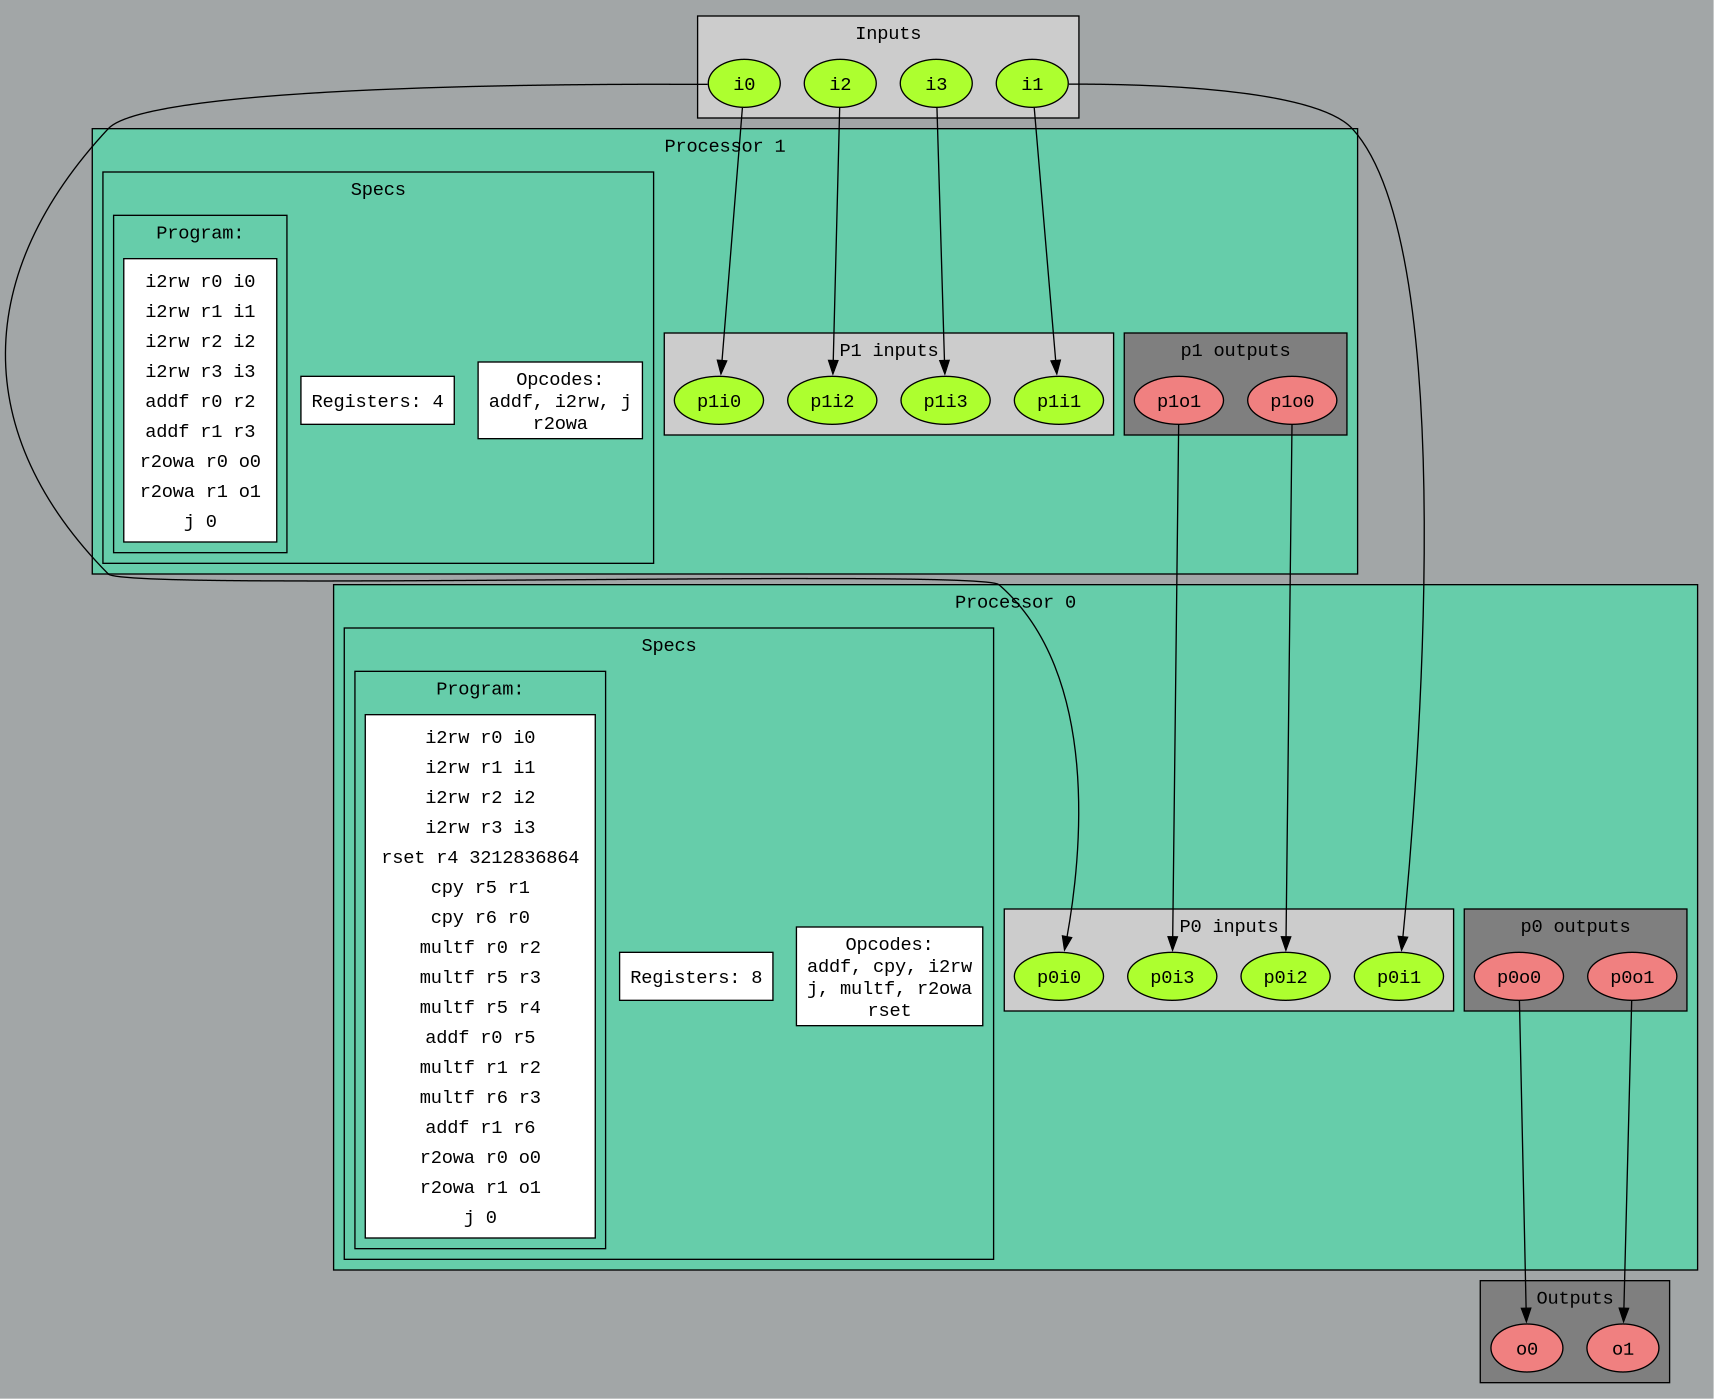

In [400]:
display.Image("bondmachine.png")

In [401]:
exec(open("generated.py").read())
import IPython.display as disp
disp.display(spExpr)

y*(y + z)

In [402]:
# Load the statistics from the JSON file as draw an histogram
with open('statistics.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame.from_dict(data, orient='index', columns=['occurrences'])
totOccurrences = df['occurrences'].sum()
newCol=mse
if totOccurrences>0:
    newCol=newCol / totOccurrences
df['error'] = newCol
df

,occurrences,error
multargfullargfull,1,0.0
addargfullargfull,1,0.0


<Axes: >

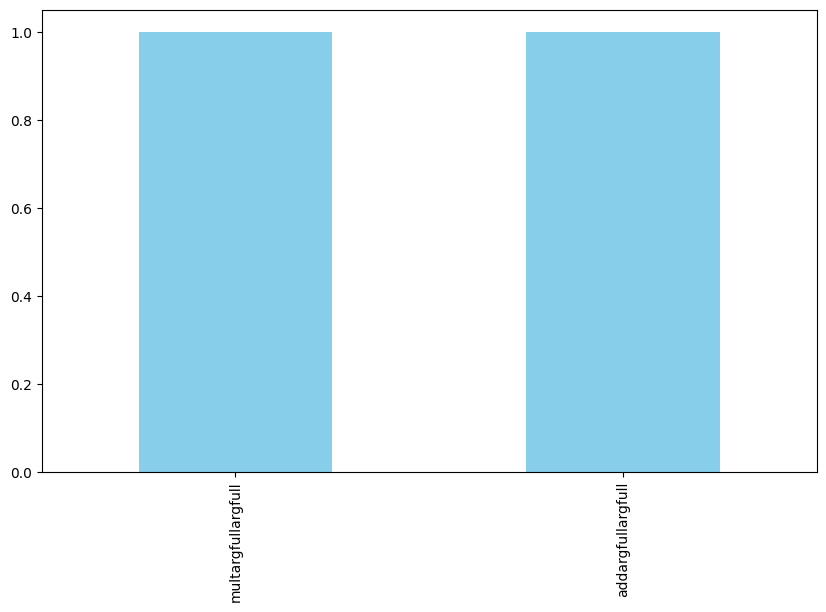

In [403]:
# Plot the histogram
df['occurrences'].plot(kind='bar', figsize=(10, 6), color='skyblue')


In [404]:
# Load the global statistics from the CSV file if it exists
if os.path.exists('global_statistics'):
	global_stats = pd.read_csv('global_statistics', index_col=0)
else:
	# Create an empty DataFrame with the same columns as the global statistics
	global_stats = pd.DataFrame(columns=['occurrences', 'error'])
global_stats

,occurrences,error
addargfullnumimag,18.0,1120.856840
addargfullnumreal,18.0,1403.919313
addargfullargfull,30.0,1440.779669
multargfullnumreal,24.0,319.900387
multargfullargfull,8.0,1404.794313
multargfullnumimag,1.0,1119.926157
addargfullnumfull,2.0,1119.926157
multargfullnumfull,2.0,36.800876
powargfullnumreal,3.0,319.863350


In [405]:
# 

In [406]:
# If the global statistics DataFrame is empty, initialize it with the same rows as the current DataFrame
for index, row in df.iterrows():
	if index not in global_stats.index:
		global_stats.loc[index] = [0.0, 0.0]

# Sum the occurrences to the global statistics if in genetating mode
if not dontGenerate:
	for index, row in df.iterrows():
		global_stats.at[index, 'occurrences'] += row['occurrences']
		global_stats.at[index, 'error'] += row['error']
# Save the updated global statistics
global_stats.to_csv('global_statistics')
global_stats


,occurrences,error
addargfullnumimag,18.0,1120.856840
addargfullnumreal,18.0,1403.919313
addargfullargfull,30.0,1440.779669
multargfullnumreal,24.0,319.900387
multargfullargfull,8.0,1404.794313
multargfullnumimag,1.0,1119.926157
addargfullnumfull,2.0,1119.926157
multargfullnumfull,2.0,36.800876
powargfullnumreal,3.0,319.863350


<Axes: >

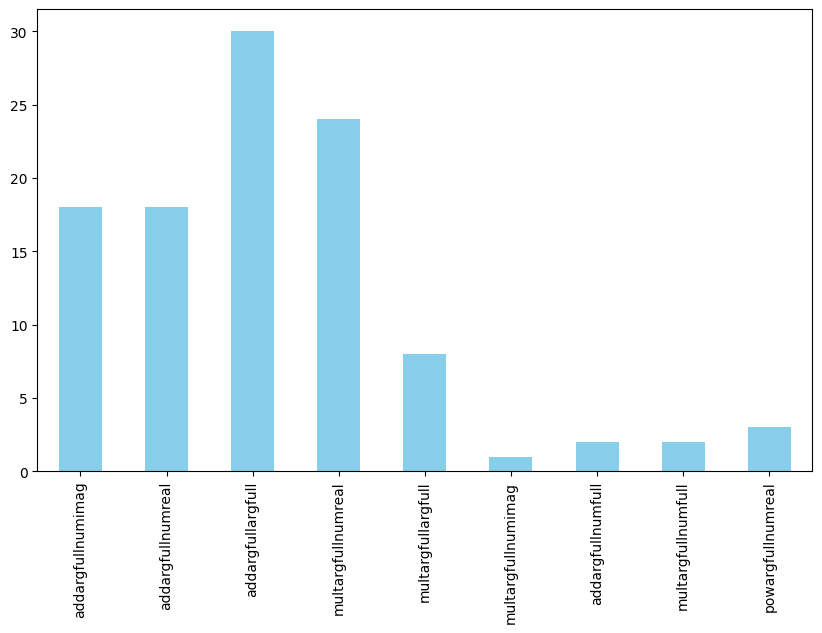

In [407]:
# Plot the histogram of the global statistics
global_stats['occurrences'].plot(kind='bar', figsize=(10, 6), color='skyblue')